## Prophet prediction for NYC electricity load & price

In [21]:
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

In [ ]:
# df_price = pd.read_csv('nyiso_price_2017.csv', parse_dates=['time_stamp', 'time_stamp_local'])
# df_load = pd.read_csv('nyiso_load_2017.csv', parse_dates=['time_stamp', 'time_stamp_local'])

In [34]:
df_price = pd.read_csv('nyiso_NYC_price.csv', parse_dates=['time_stamp', 'time_stamp_local'])

In [35]:
df_price.shape#, df_load.shape

(10197, 3)

In [36]:
may1st_index_price = (df_price.time_stamp_local >= pd.datetime(2017, 1, 1)) & \
                     (df_price.time_stamp_local < pd.datetime(2018, 2, 1))
#may1st_index_load = df_load.time_stamp_local >= pd.datetime(2017, 5, 1)

df_price = df_price.loc[may1st_index_price, :]
#df_load = df_load.loc[may1st_index_load, :]

df_price.shape#, df_load.shape

(9453, 3)

In [37]:
df_price['hour'] = df_price.time_stamp_local.apply(lambda x: x.hour)
#df_price['hour'] = pd.to_datetime(df_price['time_stamp_local'], format='%H:%M')#.dt.hour

In [38]:
df_price.head()

,time_stamp,price,time_stamp_local,hour
744,2017-01-01 05:00:00,32.28,2017-01-01 00:00:00,0
745,2017-01-01 06:00:00,30.77,2017-01-01 01:00:00,1
746,2017-01-01 07:00:00,31.17,2017-01-01 02:00:00,2
747,2017-01-01 08:00:00,32.00,2017-01-01 03:00:00,3
748,2017-01-01 09:00:00,27.89,2017-01-01 04:00:00,4


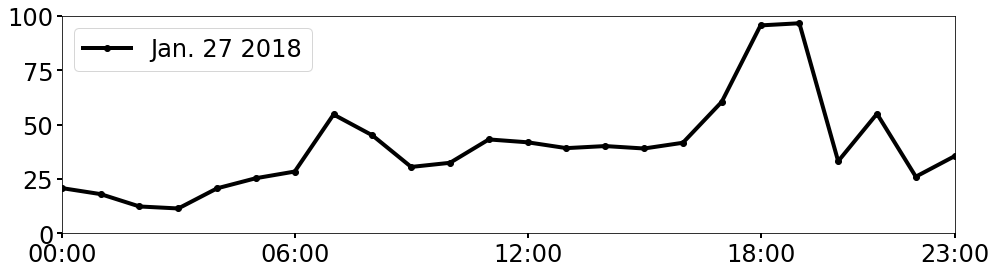

In [56]:
## leave only hour info when plotting
fig, ax = plt.subplots(nrows = 1, figsize = (16, 4))
panel01 = (df_price.time_stamp_local >= pd.datetime(2018, 1, 26)) & \
          (df_price.time_stamp_local < pd.datetime(2018, 1, 27))
ax.plot(df_price.loc[panel01, 'hour'], df_price.loc[panel01, 'price'], 'o-', linewidth = 4, 
        color = 'black', label = 'Jan. 27 2018');
#ax[0].set_xlim(pd.datetime(2017, 4, 27), pd.datetime(2017, 4, 28))
ax.set_xlim(0, 23);
ax.set_ylim(0, 100);
ax.legend(fontsize = 24);
fig.canvas.draw()
#xtickloc = [0, 6, 12, 18]
#xtickstr = ['00:00', '06:00', '12:00', '18:00']
#ax.set_xticklabels(xtickloc, xtickstr)
#ax.tick_params(axis='both',which='both',labelsize=24,\
#        length=5,width=2,direction='out');
#tick_locs = ax.get_xticks()
new_tick_locs = [0, 6, 12, 18, 23]
new_tick_labels = ['00:00', '06:00', '12:00', '18:00', '23:00']
ax.set_xticks(new_tick_locs)
ax.set_xticklabels(new_tick_labels)
ax.tick_params(axis='both',which='both',labelsize=24,\
        length=5,width=2,direction='out');

#ax.set_ylabel('$/MWh', fontsize = 24)
plt.savefig('one_day_price.pdf', format = 'pdf')

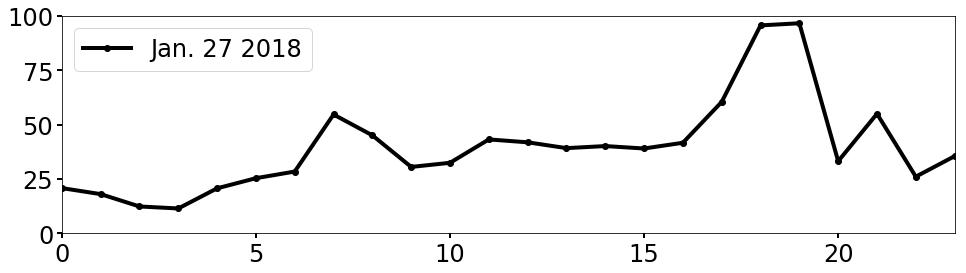

In [39]:
## leave only hour info when plotting
fig, ax = plt.subplots(nrows = 1, figsize = (16, 4))
panel01 = (df_price.time_stamp_local >= pd.datetime(2018, 1, 26)) & \
          (df_price.time_stamp_local < pd.datetime(2018, 1, 27))
ax.plot(df_price.loc[panel01, 'hour'], df_price.loc[panel01, 'price'], 'o-', linewidth = 4, 
        color = 'black', label = 'Jan. 27 2018');
#ax[0].set_xlim(pd.datetime(2017, 4, 27), pd.datetime(2017, 4, 28))
ax.set_xlim(0, 23);
ax.set_ylim(0, 100);
ax.legend(fontsize = 24);
ax.tick_params(axis='both',which='both',labelsize=24,\
        length=5,width=2,direction='out');
#ax.set_ylabel('$/MWh', fontsize = 24)
# plt.savefig('one_day_price.pdf', format = 'pdf')

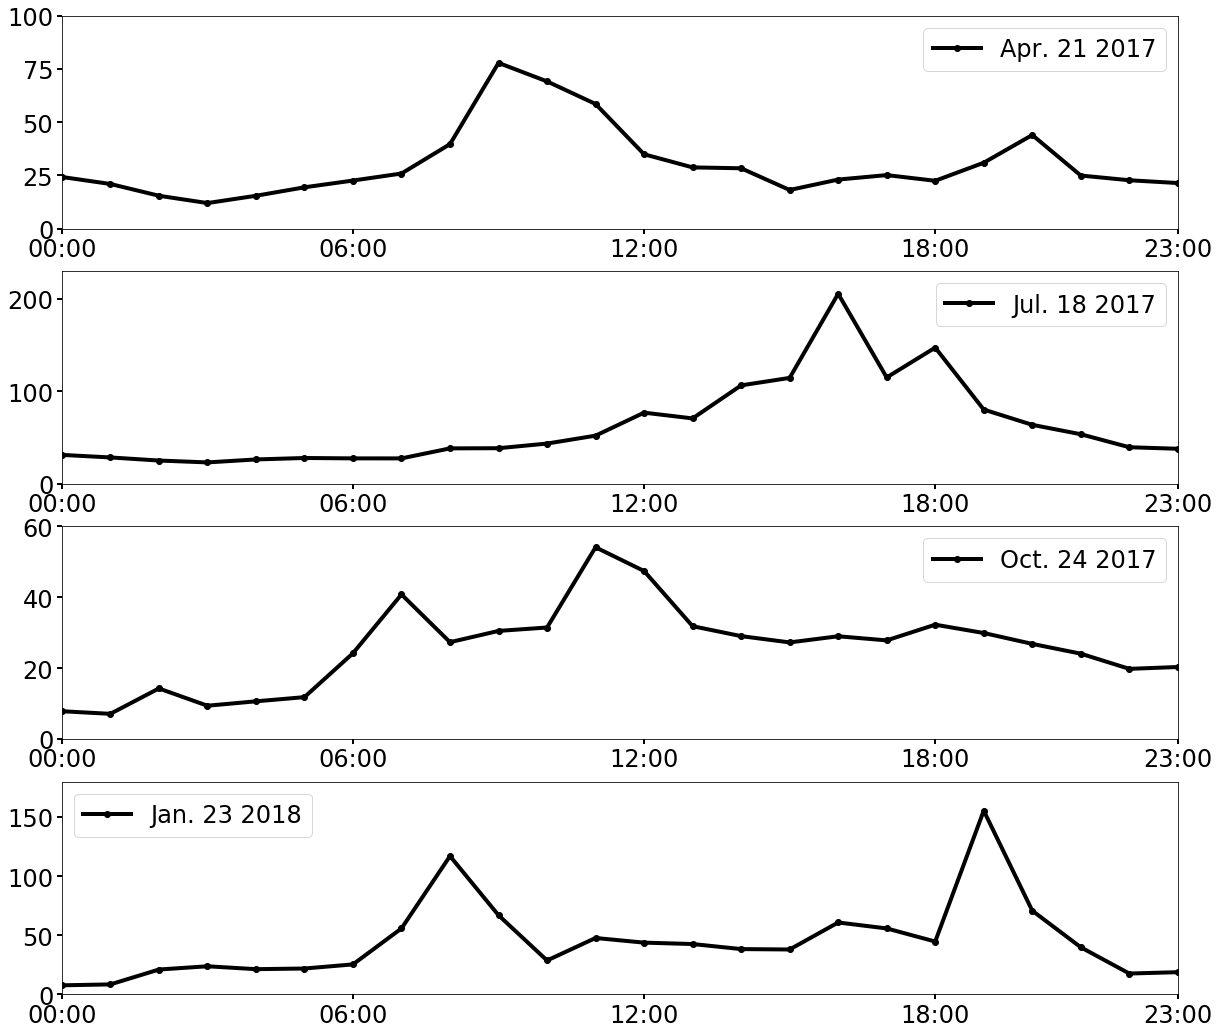

In [59]:
## leave only hour info when plotting
new_tick_locs = [0, 6, 12, 18, 23]
new_tick_labels = ['00:00', '06:00', '12:00', '18:00', '23:00']


fig, ax = plt.subplots(nrows = 4, figsize = (20, 18))
panel01 = (df_price.time_stamp_local >= pd.datetime(2017, 4, 21)) & \
          (df_price.time_stamp_local < pd.datetime(2017, 4, 22))
ax[0].plot(df_price.loc[panel01, 'hour'], df_price.loc[panel01, 'price'], 'o-', linewidth = 4, 
        color = 'black', label = 'Apr. 21 2017');
#ax[0].set_xlim(pd.datetime(2017, 4, 27), pd.datetime(2017, 4, 28))
ax[0].set_xlim(0, 23);
ax[0].set_ylim(0, 100);
ax[0].legend(fontsize = 24);
ax[0].set_xticks(new_tick_locs)
ax[0].set_xticklabels(new_tick_labels)
ax[0].tick_params(axis='both',which='both',labelsize=24,\
        length=5,width=2,direction='out');
#ax[0].set_ylabel('$/MWh', fontsize = 24);

panel02 = (df_price.time_stamp_local >= pd.datetime(2017, 7, 18)) & \
          (df_price.time_stamp_local < pd.datetime(2017, 7, 19))
ax[1].plot(df_price.loc[panel02, 'hour'], df_price.loc[panel02, 'price'], 'o-', linewidth = 4, 
        color = 'black', label = 'Jul. 18 2017');
#ax[1].set_xlim(pd.datetime(2017, 7, 18), pd.datetime(2017, 7, 19))
ax[1].set_xlim(0, 23);
ax[1].set_ylim(0, 230);
ax[1].legend(fontsize = 24);
ax[1].set_xticks(new_tick_locs)
ax[1].set_xticklabels(new_tick_labels)
ax[1].tick_params(axis='both',which='both',labelsize=24,\
        length=5,width=2,direction='out');
#ax[1].set_ylabel('$/MWh', fontsize = 24);

panel03 = (df_price.time_stamp_local >= pd.datetime(2017, 10, 23)) & \
          (df_price.time_stamp_local < pd.datetime(2017, 10, 24))
ax[2].plot(df_price.loc[panel03, 'hour'], df_price.loc[panel03, 'price'], 'o-', linewidth = 4, 
        color = 'black', label = 'Oct. 24 2017');
#ax[2].set_xlim(pd.datetime(2017, 10, 23), pd.datetime(2017, 10, 24))
ax[2].set_xlim(0, 23);
ax[2].set_ylim(0, 60);
ax[2].legend(fontsize = 24);
ax[2].set_xticks(new_tick_locs)
ax[2].set_xticklabels(new_tick_labels)
ax[2].tick_params(axis='both',which='both',labelsize=24,\
        length=5,width=2,direction='out');
#ax[2].set_ylabel('$/MWh', fontsize = 24);

panel04 = (df_price.time_stamp_local >= pd.datetime(2018, 1, 23)) & \
          (df_price.time_stamp_local < pd.datetime(2018, 1, 24))
ax[3].plot(df_price.loc[panel04, 'hour'], df_price.loc[panel04, 'price'], 'o-', linewidth = 4, 
        color = 'black', label = 'Jan. 23 2018');
#ax[3].set_xlim(pd.datetime(2018, 1, 23), pd.datetime(2018, 1, 24))
ax[3].set_xlim(0, 23);
ax[3].set_ylim(0, 180);
ax[3].tick_params(axis='both',which='both',labelsize=24,\
        length=5,width=2,direction='out');
ax[3].set_xticks(new_tick_locs)
ax[3].set_xticklabels(new_tick_labels)
ax[3].legend(fontsize = 24);
#ax[3].set_ylabel('$/MWh', fontsize = 24);
plt.savefig('day_to_day_price.pdf', format = 'pdf')

In [109]:
df_price.head()

,time_stamp,price,time_stamp_local,hour
1416,2017-01-29 05:00:00,20.84,2017-01-29 00:00:00,0
1417,2017-01-29 06:00:00,26.55,2017-01-29 01:00:00,1
1418,2017-01-29 07:00:00,24.94,2017-01-29 02:00:00,2
1419,2017-01-29 08:00:00,28.24,2017-01-29 03:00:00,3
1420,2017-01-29 09:00:00,27.59,2017-01-29 04:00:00,4


In [110]:
# df_price['lbmp_price_scaled'] = preprocessing.scale(df_price.lbmp_price)
# df_load['load_scaled'] = preprocessing.scale(df_load.load)

In [111]:
df_price.drop(['time_stamp_local', 'hour'], axis = 1, inplace = True)
#df_load.drop(['time_stamp_local'], axis = 1, inplace = True)

In [112]:
# df_load.head()

In [113]:
df_price.columns = ['ds', 'y']
# df_load.columns = ['ds', 'y']

In [114]:
df_price.tail()

,ds,y
10171,2018-01-29 00:00:00,47.02
10172,2018-01-29 01:00:00,53.99
10173,2018-01-29 02:00:00,39.47
10174,2018-01-29 03:00:00,23.19
10175,2018-01-29 04:00:00,23.20


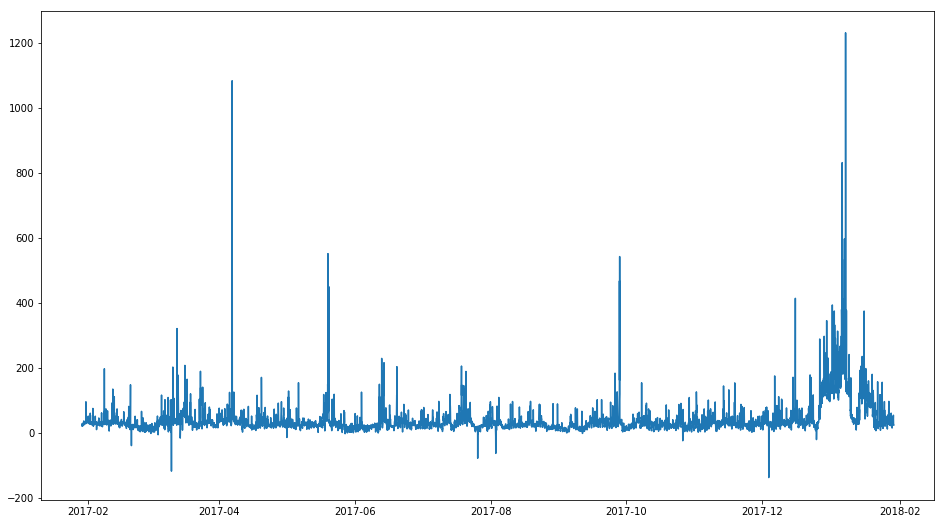

In [115]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(df_price.iloc[:,0], df_price.iloc[:,1])
#ax.plot(df_load.iloc[:,0], df_load.iloc[:,1])
#plt.xlim(pd.datetime(2018,1,14,5), pd.datetime(2018,1,16,5))
#plt.ylim(-1, 4)

In [116]:
df_price.shape

(8760, 2)

In [117]:
percentage = 0.9

## Validate

In [118]:
m = Prophet()
m.fit(df_price.iloc[:int(df_price.shape[0] * percentage), :]);
# future = m.make_future_dataframe(periods=12)
# future = df_price.iloc[int(df_price.shape[0] * percentage):, :].drop('y', axis = 1)
future = df_price.drop('y', axis = 1)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [119]:
forecast.shape, int(df_price.shape[0] * percentage)

((8760, 19), 7884)

In [120]:
forecast.columns

Index(['ds', 'trend', 'trend_lower', 'trend_upper', 'yhat_lower', 'yhat_upper',
       'daily', 'daily_lower', 'daily_upper', 'seasonal', 'seasonal_lower',
       'seasonal_upper', 'seasonalities', 'seasonalities_lower',
       'seasonalities_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yhat'],
      dtype='object')

In [122]:
np.sqrt(mean_squared_error(forecast.yhat.iloc[int(df_price.shape[0] * percentage):].values, df_price.iloc[int(df_price.shape[0] * percentage):, 1].values))

111.55025859642413

## Forecast

In [142]:
Prophet?

In [ ]:
m = Prophet()
m.fit(df_price);
future = m.make_future_dataframe(freq='H',periods=24 *7)
forecast = m.predict(future)

(736330.0, 736730.0)

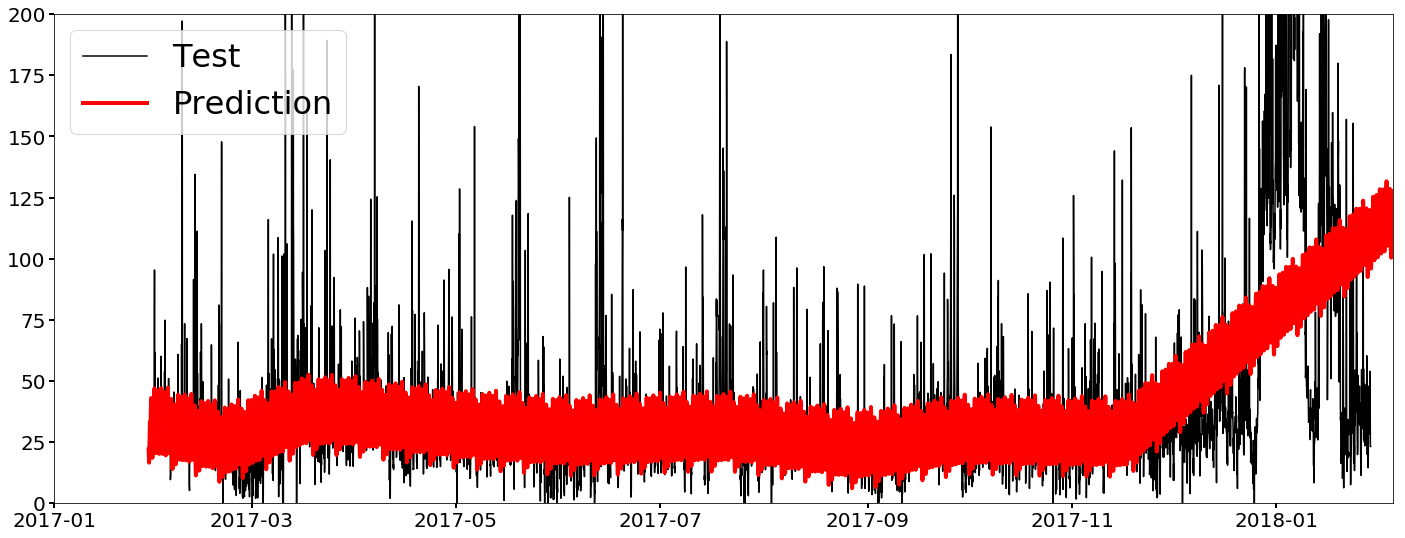

In [139]:
fig, ax = plt.subplots(figsize = (24, 9))
ax.plot(df_price.iloc[:, 0], 
        df_price.iloc[:, 1], color = 'black', label = 'Test');
# ax.plot(df_price.iloc[:int(df_price.shape[0] * percentage), 0], 
#         df_price.iloc[:int(df_price.shape[0] * percentage), 1], '.', color = 'black', label = 'Train');
ax.plot(forecast.ds, 
        forecast.yhat, linewidth = 4,
        color = 'red', label = 'Prediction');
#ax.fill_between(forecast.index, forecast.yhat_lower, forecast.yhat_upper)
ax.tick_params(axis='both',which='both',labelsize=20,\
        length=5,width=2,direction='out');
ax.legend(fontsize = 32);
#ax.set_ylim(-20, 2100)
ax.set_ylim(0, 200)
ax.set_xlim(pd.datetime(2017,1,1), pd.datetime(2018,2,5))
#plt.savefig('prophet_2017.pdf', format = 'pdf')

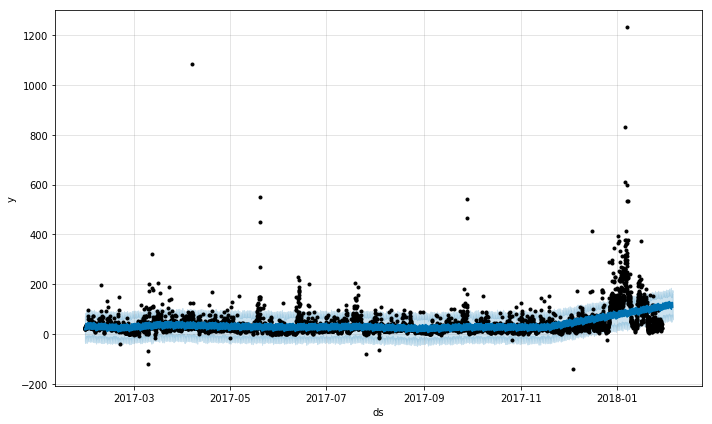

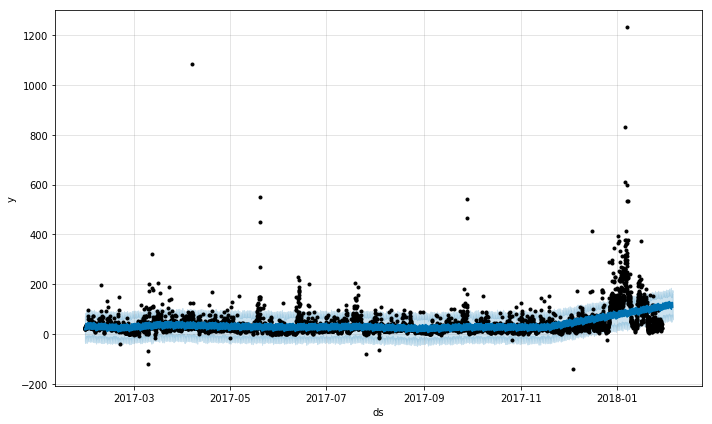

In [140]:
#fig, ax = plt.subplot(figsize = (16, 9))
m.plot(forecast)

In [ ]:
# forecast.to_csv('forecast' + 'nyiso_2016_2017.csv', index = False)